# Models For Prediction (Comparison)

In [352]:
#
import os
import numpy as np
import pandas as pd
from pandas import Timestamp
import seaborn as sns
import matplotlib.pyplot as plt
#
from talib import RSI, BBANDS, MACD, ATR
#
from zipline.api import order_target_percent, record, symbol, set_benchmark, get_open_orders
import zipline
import datetime
import pytz
from zipline.data.bundles import load
from trading_calendars import get_calendar
import pyfolio as pf
#
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
#
from matplotlib.ticker import FuncFormatter
%load_ext zipline

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


## Load and Prep Data

### General Factors

In [274]:
df = pd.read_csv("../data/signals/General_Factors.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.index = pd.MultiIndex.from_frame(df.iloc[:,0:2])
df = df.drop(["Symbol", "Date"], axis=1)
df = df.dropna()

# what are lagged returns used for
df = df.drop([c for c in df.columns if 'lag' in c], axis=1)
df = df.drop(['Open', 'High', 'Low', 'Close'], axis=1)

df

Volume        rsi   bb_high    bb_low       atr  \
Symbol Date                                                                
ADA    2018-06-11  1.004216e+08  33.512455  0.216036  0.021987 -0.404601   
       2018-06-12  6.949217e+07  30.063208  0.269702 -0.021351 -0.405151   
       2018-06-13  7.014928e+07  28.857432  0.291623 -0.010164 -0.409419   
       2018-06-14  1.431842e+08  35.174686  0.254994  0.077835 -0.408323   
       2018-06-15  8.906098e+07  33.089452  0.282673  0.061770 -0.420484   
...                         ...        ...       ...       ...       ...   
TFUEL  2022-03-16  2.340533e+07  47.924529  0.091847  0.112104  0.145477   
       2022-03-17  2.249906e+07  50.268468  0.071962  0.129365  0.125531   
       2022-03-18  2.254040e+07  52.445625  0.054721  0.145075  0.130008   
       2022-03-19  2.129223e+07  53.545190  0.050250  0.152796  0.115289   
       2022-03-20  1.999143e+07  49.873470  0.064820  0.124119  0.087470   

                       macd  return_1d  return_2d  return_3d  return_4d  ...  \
Symbol Date                                                              ...   
ADA    2018-06-11 -0.349924   0.011576  -0.062333  -0.044647  -0.038902  ...   
       2018-06-12 -0.383543  -0.079092  -0.034822  -0.067953  -0.053377  ...   
       2018-06-13 -0.413876  -0.032376  -0.056023  -0.034007  -0.059183  ...   
       2018-06-14 -0.416873   0.075489   0.020132  -0.014077  -0.007726  ...   
       2018-06-15 -0.426485  -0.046255   0.012789  -0.002495  -0.022222  ...   
...                     ...        ...        ...        ...        ...  ...   
TFUEL  2022-03-16 -0.495777   0.020510   0.004641   0.011658   0.000422  ...   
       2022-03-17 -0.423620   0.022745   0.021627   0.010640   0.014418  ...   
       2022-03-18 -0.340504   0.021005   0.021875   0.021420   0.013221  ...   
       2022-03-19 -0.260929   0.010329   0.015653   0.018012   0.018636  ...   
       2022-03-20 -0.229633  -0.030225  -0.010156   0.000124   0.005732  ...   

                   month_3  month_4  month_5  month_6  month_7  month_8  \
Symbol Date                                                               
ADA    2018-06-11        0        0        0        1        0        0   
       2018-06-12        0        0        0        1        0        0   
       2018-06-13        0        0        0        1        0        0   
       2018-06-14        0        0        0        1        0        0   
       2018-06-15        0        0        0        1        0        0   
...                    ...      ...      ...      ...      ...      ...   
TFUEL  2022-03-16        1        0        0        0        0        0   
       2022-03-17        1        0        0        0        0        0   
       2022-03-18        1        0        0        0        0        0   
       2022-03-19        1        0        0        0        0        0   
       2022-03-20        1        0        0        0        0        0   

                   month_9  month_10  month_11  month_12  
Symbol Date                                               
ADA    2018-06-11        0         0         0         0  
       2018-06-12        0         0         0         0  
       2018-06-13        0         0         0         0  
       2018-06-14        0         0         0         0  
       2018-06-15        0         0         0         0  
...                    ...       ...       ...       ...  
TFUEL  2022-03-16        0         0         0         0  
       2022-03-17        0         0         0         0  
       2022-03-18        0         0         0         0  
       2022-03-19        0         0         0         0  
       2022-03-20        0         0         0         0  

[9653 rows x 40 columns]

### NFT and Sentiment  Data

In [275]:
nft_df = pd.read_csv("../data/NFT_markettracker.csv").drop("Unnamed: 0", axis=1)
nft_df["Date"] = pd.to_datetime(nft_df["Date"])
nft_df.head()

,Date,Number of sales,Sales USD,Average USD,Active market wallets,Primary Sales,Secondary sales,Primary sales USD,Secondary sales USD,Unique buyers,Unique sellers
0,2017-10-02,0,0.00,NaN,0,0,0,0.0,0.00,0,0
1,2017-10-03,0,0.00,NaN,0,0,0,0.0,0.00,0,0
2,2017-10-04,1,58.61,58.61,2,0,1,0.0,58.61,1,1
3,2017-10-05,0,0.00,NaN,0,0,0,0.0,0.00,0,0
4,2017-10-06,0,0.00,NaN,0,0,0,0.0,0.00,0,0


In [276]:
sent_df = pd.read_csv("../data/signals/Reddit_NFT_Agg.csv")
sent_df["Date"] = pd.to_datetime(nft_df["Date"])
sent_df.head()

,Date,Polarity_Sum,Polarity_Mean,Sentiment
0,2017-10-02,0.0,0.0,0
1,2017-10-03,0.0,0.0,0
2,2017-10-04,0.0,0.0,0
3,2017-10-05,0.0,0.0,0
4,2017-10-06,0.0,0.0,0


Combine NFT and Sentiment with general factors and returns

In [277]:
initial_date = df.index.get_level_values("Date")[0]
end_date = df.index.get_level_values("Date")[-1]

nft_df = nft_df[(nft_df["Date"] >= initial_date) & (nft_df["Date"] <= end_date)].drop("Date", axis=1).reset_index().drop("index", axis=1)
sent_df = sent_df[(sent_df["Date"] >= initial_date) & (sent_df["Date"] <= end_date)].drop("Date", axis=1).reset_index().drop("index", axis=1)

len(nft_df) == len(df.loc["ADA",:]) and len(sent_df) == len(df.loc["ADA",:])

True

In [278]:
tiled_df1 = pd.DataFrame(np.tile(nft_df, (7,1)), columns=nft_df.columns)
tiled_df2 = pd.DataFrame(np.tile(sent_df, (7,1)), columns=sent_df.columns)

len(tiled_df1) == len(df) and len(tiled_df2) == len(df)

True

In [279]:
df[tiled_df1.columns] = tiled_df1.values
df[tiled_df2.columns] = tiled_df2.values
df

Volume        rsi   bb_high    bb_low       atr  \
Symbol Date                                                                
ADA    2018-06-11  1.004216e+08  33.512455  0.216036  0.021987 -0.404601   
       2018-06-12  6.949217e+07  30.063208  0.269702 -0.021351 -0.405151   
       2018-06-13  7.014928e+07  28.857432  0.291623 -0.010164 -0.409419   
       2018-06-14  1.431842e+08  35.174686  0.254994  0.077835 -0.408323   
       2018-06-15  8.906098e+07  33.089452  0.282673  0.061770 -0.420484   
...                         ...        ...       ...       ...       ...   
TFUEL  2022-03-16  2.340533e+07  47.924529  0.091847  0.112104  0.145477   
       2022-03-17  2.249906e+07  50.268468  0.071962  0.129365  0.125531   
       2022-03-18  2.254040e+07  52.445625  0.054721  0.145075  0.130008   
       2022-03-19  2.129223e+07  53.545190  0.050250  0.152796  0.115289   
       2022-03-20  1.999143e+07  49.873470  0.064820  0.124119  0.087470   

                       macd  return_1d  return_2d  return_3d  return_4d  ...  \
Symbol Date                                                              ...   
ADA    2018-06-11 -0.349924   0.011576  -0.062333  -0.044647  -0.038902  ...   
       2018-06-12 -0.383543  -0.079092  -0.034822  -0.067953  -0.053377  ...   
       2018-06-13 -0.413876  -0.032376  -0.056023  -0.034007  -0.059183  ...   
       2018-06-14 -0.416873   0.075489   0.020132  -0.014077  -0.007726  ...   
       2018-06-15 -0.426485  -0.046255   0.012789  -0.002495  -0.022222  ...   
...                     ...        ...        ...        ...        ...  ...   
TFUEL  2022-03-16 -0.495777   0.020510   0.004641   0.011658   0.000422  ...   
       2022-03-17 -0.423620   0.022745   0.021627   0.010640   0.014418  ...   
       2022-03-18 -0.340504   0.021005   0.021875   0.021420   0.013221  ...   
       2022-03-19 -0.260929   0.010329   0.015653   0.018012   0.018636  ...   
       2022-03-20 -0.229633  -0.030225  -0.010156   0.000124   0.005732  ...   

                   Active market wallets  Primary Sales  Secondary sales  \
Symbol Date                                                                
ADA    2018-06-11                  660.0         2864.0            517.0   
       2018-06-12                  692.0         2296.0            607.0   
       2018-06-13                  718.0         1671.0            601.0   
       2018-06-14                  566.0         1556.0            370.0   
       2018-06-15                  641.0         4665.0            588.0   
...                                  ...            ...              ...   
TFUEL  2022-03-16                14188.0         2802.0           8912.0   
       2022-03-17                14414.0         3109.0           9892.0   
       2022-03-18                15830.0         3121.0          10624.0   
       2022-03-19                17014.0         4497.0          11419.0   
       2022-03-20                15276.0         4826.0           9934.0   

                   Primary sales USD  Secondary sales USD  Unique buyers  \
Symbol Date                                                                
ADA    2018-06-11           20244.22             22356.97          492.0   
       2018-06-12           18200.13             18781.24          504.0   
       2018-06-13           23514.14             27754.78          527.0   
       2018-06-14           14447.34             31315.95          432.0   
       2018-06-15           26308.40             24206.09          450.0   
...                              ...                  ...            ...   
TFUEL  2022-03-16         2356432.46          52330293.33         7755.0   
       2022-03-17         3957555.73          98901027.48         8040.0   
       2022-03-18         5639611.59          80177042.29         8538.0   
       2022-03-19         5475732.05          82829439.82         9487.0   
       2022-03-20         2497767.37          41409906.92         8709.0   

                 

In [175]:
print([i for i in df.columns])

['Volume', 'rsi', 'bb_high', 'bb_low', 'atr', 'macd', 'return_1d', 'return_2d', 'return_3d', 'return_4d', 'return_5d', 'return_6d', 'return_7d', 'return_14d', 'return_28d', 'target_1d', 'target_2d', 'target_3d', 'target_4d', 'target_5d', 'target_6d', 'target_7d', 'target_14d', 'target_28d', 'year_2018', 'year_2019', 'year_2020', 'year_2021', 'year_2022', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'Number of sales', 'Sales USD', 'Average USD', 'Active market wallets', 'Primary Sales', 'Secondary sales', 'Primary sales USD', 'Secondary sales USD', 'Unique buyers', 'Unique sellers', 'Polarity_Sum', 'Polarity_Mean', 'Sentiment']


In [280]:
# Machine Learning for Algorithmic Trading Chapter 6
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='Date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start])
                             & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [282]:
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      kind='reg')
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')

In [283]:
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

In [284]:
def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    rolling_result.ic.plot(ax=axes[0],
                           title=f'Information Coefficient (Mean: {mean_ic:.2f})',
                           lw=1)
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = df.rmse.mean()
    rolling_result.rmse.plot(ax=axes[1],
                             title=f'Root Mean Squared Error (Mean: {mean_rmse:.2%})',
                             lw=1,
                             ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    sns.despine()
    plt.tight_layout()

## Models

Target and Features

In [194]:
y = df.filter(like='target')
X = df.drop(y.columns, axis=1)
X = X.drop(["Volume"], axis=1)
X = X.drop(X.columns[4:14], axis=1)
X

rsi   bb_high    bb_low       atr  year_2018  \
Symbol Date                                                             
ADA    2018-06-11  33.512455  0.216036  0.021987 -0.404601          1   
       2018-06-12  30.063208  0.269702 -0.021351 -0.405151          1   
       2018-06-13  28.857432  0.291623 -0.010164 -0.409419          1   
       2018-06-14  35.174686  0.254994  0.077835 -0.408323          1   
       2018-06-15  33.089452  0.282673  0.061770 -0.420484          1   
...                      ...       ...       ...       ...        ...   
TFUEL  2022-03-16  47.924529  0.091847  0.112104  0.145477          0   
       2022-03-17  50.268468  0.071962  0.129365  0.125531          0   
       2022-03-18  52.445625  0.054721  0.145075  0.130008          0   
       2022-03-19  53.545190  0.050250  0.152796  0.115289          0   
       2022-03-20  49.873470  0.064820  0.124119  0.087470          0   

                   year_2019  year_2020  year_2021  year_2022  month_2  ...  \
Symbol Date                                                             ...   
ADA    2018-06-11          0          0          0          0        0  ...   
       2018-06-12          0          0          0          0        0  ...   
       2018-06-13          0          0          0          0        0  ...   
       2018-06-14          0          0          0          0        0  ...   
       2018-06-15          0          0          0          0        0  ...   
...                      ...        ...        ...        ...      ...  ...   
TFUEL  2022-03-16          0          0          0          1        0  ...   
       2022-03-17          0          0          0          1        0  ...   
       2022-03-18          0          0          0          1        0  ...   
       2022-03-19          0          0          0          1        0  ...   
       2022-03-20          0          0          0          1        0  ...   

                   Active market wallets  Primary Sales  Secondary sales  \
Symbol Date                                                                
ADA    2018-06-11                  660.0         2864.0            517.0   
       2018-06-12                  692.0         2296.0            607.0   
       2018-06-13                  718.0         1671.0            601.0   
       2018-06-14                  566.0         1556.0            370.0   
       2018-06-15                  641.0         4665.0            588.0   
...                                  ...            ...              ...   
TFUEL  2022-03-16                14188.0         2802.0           8912.0   
       2022-03-17                14414.0         3109.0           9892.0   
       2022-03-18                15830.0         3121.0          10624.0   
       2022-03-19                17014.0         4497.0          11419.0   
       2022-03-20                15276.0         4826.0           9934.0   

                   Primary sales USD  Secondary sales USD  Unique buyers  \
Symbol Date                                                                
ADA    2018-06-11           20244.22             22356.97          492.0   
       2018-06-12           18200.13             18781.24          504.0   
       2018-06-13           23514.14             27754.78          527.0   
       2018-06-14           14447.34             31315.95          432.0   
       2018-06-15           26308.40             24206.09          450.0   
...                              ...                  ...            ...   
TFUEL  2022-03-16         2356432.46          52330293.33         7755.0   
       2022-03-17         3957555.73          98901027.48         8040.0   
       2022-03-18         5639611.59          80177042.29         8538.0   
       2022-03-19         5475732.05          82829439.82         9487.0   
       2022-03-20         2497767.37          41409906.92         8709.0   

                   Unique sellers  Polarity_Sum  Polarity_Mean  Senti

Cross-validation indices

In [195]:
YEAR = 365 # number of trading days
train_period_length = 28 # number of TRAINING DAYS
test_period_length = 7 # number of TESTING DAYS, i.e. number of 1d returns to predict
n_splits = int(3 * YEAR/test_period_length)
lookahead = 1 # return period

# cross-validation
cv = MultipleTimeSeriesCV(n_splits=n_splits,
    test_period_length=test_period_length,
    lookahead=lookahead,
    train_period_length=train_period_length)

### Training

#### All Features

In [196]:
%%time
target = f'target_{lookahead}d'

model_names = ("ols", "rf", "xgb")

lr = LinearRegression()
rf = RandomForestRegressor()
xgb = XGBRegressor()

models = (lr, rf, xgb)

eval_dict = {}

for name, model in zip(model_names, models):
    model_predictions, model_scores = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
        
        # model specific
        model.fit(X=X_train, y=y_train) 
        y_pred = model.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='Date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')], axis=1)

        model_scores.append(scores)
        model_predictions.append(preds)
    
    eval_dict[f"{name}_predictions"], eval_dict[f"{name}_scores"] = pd.concat(model_predictions), pd.concat(model_scores)

CPU times: total: 3min 8s
Wall time: 1min 8s


In [197]:
for name in model_names:
    model_r, model_p = spearmanr(eval_dict[f"{name}_predictions"].actuals, eval_dict[f"{name}_predictions"].predicted)
    print(f'{name}: Information Coefficient (overall): {model_r:.3%} (p-value: {model_p:.4%})')

ols: Information Coefficient (overall): -0.446% (p-value: 69.6897%)
rf: Information Coefficient (overall): 0.103% (p-value: 92.8403%)
xgb: Information Coefficient (overall): 0.233% (p-value: 83.8414%)


ols
rf
xgb


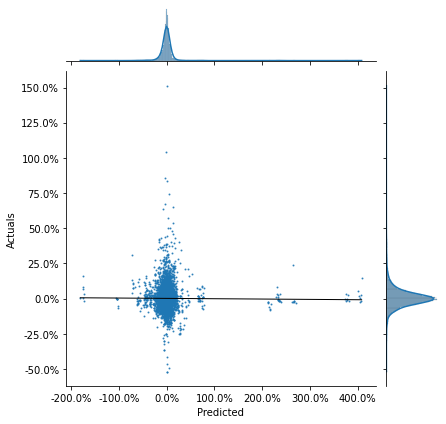

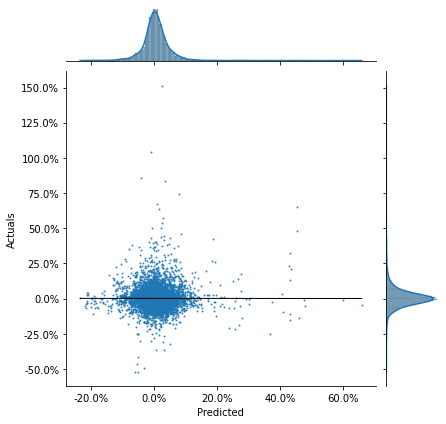

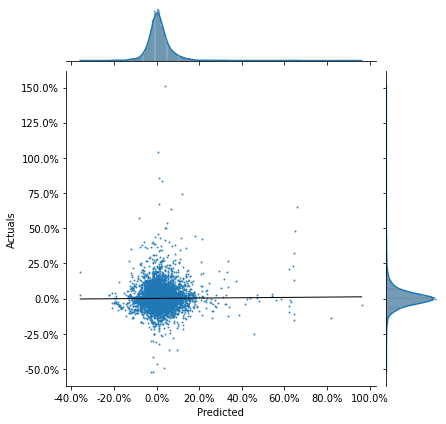

In [198]:
symbols = ("ADA", "SOL", "MANA", "MATIC", "TFUEL", "FLOW", "AVAX")

for name in model_names:
    print(name)
    #for symbol in symbols:
    plot_preds_scatter(eval_dict[f"{name}_predictions"])

In [200]:
eval_dict['rf_predictions']

actuals  predicted
Symbol Date                           
ADA    2022-03-14 -0.003871   0.002977
       2022-03-15  0.049287   0.004766
       2022-03-16 -0.002109   0.012983
       2022-03-17  0.019658  -0.018404
       2022-03-18  0.055110   0.024092
...                     ...        ...
TFUEL  2019-03-27 -0.019334   0.019647
       2019-03-28 -0.051067   0.019351
       2019-03-29 -0.065011  -0.004534
       2019-03-30 -0.018317  -0.009292
       2019-03-31 -0.046425  -0.008397

[7644 rows x 2 columns]

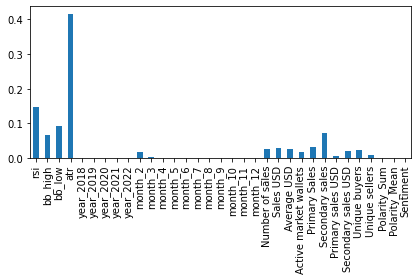

In [219]:
forest_importances = pd.Series(models[1].feature_importances_, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
fig.tight_layout()

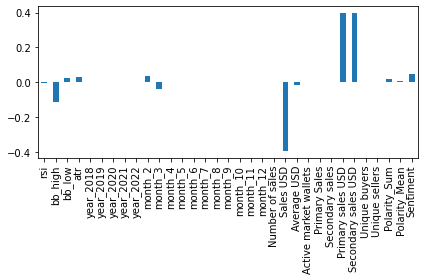

In [218]:
lr_importances = pd.Series(models[0].coef_, index=X.columns)

fig, ax = plt.subplots()
lr_importances.plot.bar(ax=ax)
fig.tight_layout()

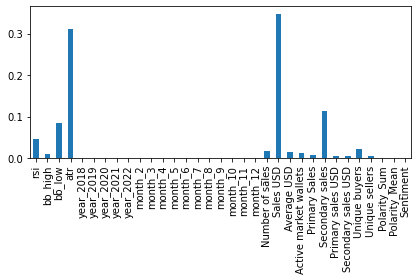

In [217]:
xgb_importances = pd.Series(models[2].feature_importances_, index=X.columns)

fig, ax = plt.subplots()
xgb_importances.plot.bar(ax=ax)
fig.tight_layout()

#### The Culling

In [285]:
df.columns

Index(['Volume', 'rsi', 'bb_high', 'bb_low', 'atr', 'macd', 'return_1d',
       'return_2d', 'return_3d', 'return_4d', 'return_5d', 'return_6d',
       'return_7d', 'return_14d', 'return_28d', 'target_1d', 'target_2d',
       'target_3d', 'target_4d', 'target_5d', 'target_6d', 'target_7d',
       'target_14d', 'target_28d', 'year_2018', 'year_2019', 'year_2020',
       'year_2021', 'year_2022', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'Number of sales', 'Sales USD', 'Average USD',
       'Active market wallets', 'Primary Sales', 'Secondary sales',
       'Primary sales USD', 'Secondary sales USD', 'Unique buyers',
       'Unique sellers', 'Polarity_Sum', 'Polarity_Mean', 'Sentiment'],
      dtype='object')

Year and month features are not useful to the models.

In [286]:
y = df.filter(like='target')
X = df.drop(y.columns, axis=1)
X = X.drop(["Volume", "Polarity_Mean"], axis=1)
X = X.drop(X.columns[5:30], axis=1)
X

rsi   bb_high    bb_low       atr      macd  \
Symbol Date                                                            
ADA    2018-06-11  33.512455  0.216036  0.021987 -0.404601 -0.349924   
       2018-06-12  30.063208  0.269702 -0.021351 -0.405151 -0.383543   
       2018-06-13  28.857432  0.291623 -0.010164 -0.409419 -0.413876   
       2018-06-14  35.174686  0.254994  0.077835 -0.408323 -0.416873   
       2018-06-15  33.089452  0.282673  0.061770 -0.420484 -0.426485   
...                      ...       ...       ...       ...       ...   
TFUEL  2022-03-16  47.924529  0.091847  0.112104  0.145477 -0.495777   
       2022-03-17  50.268468  0.071962  0.129365  0.125531 -0.423620   
       2022-03-18  52.445625  0.054721  0.145075  0.130008 -0.340504   
       2022-03-19  53.545190  0.050250  0.152796  0.115289 -0.260929   
       2022-03-20  49.873470  0.064820  0.124119  0.087470 -0.229633   

                   Number of sales     Sales USD  Average USD  \
Symbol Date                                                     
ADA    2018-06-11           3381.0  4.260119e+04        12.60   
       2018-06-12           2903.0  3.698138e+04        12.74   
       2018-06-13           2272.0  5.126892e+04        22.57   
       2018-06-14           1926.0  4.576329e+04        23.76   
       2018-06-15           5253.0  5.051450e+04         9.62   
...                            ...           ...          ...   
TFUEL  2022-03-16          11714.0  5.468673e+07      4668.49   
       2022-03-17          13001.0  1.028586e+08      7911.59   
       2022-03-18          13745.0  8.581665e+07      6243.48   
       2022-03-19          15916.0  8.830517e+07      5548.20   
       2022-03-20          14760.0  4.390767e+07      2974.77   

                   Active market wallets  Primary Sales  Secondary sales  \
Symbol Date                                                                
ADA    2018-06-11                  660.0         2864.0            517.0   
       2018-06-12                  692.0         2296.0            607.0   
       2018-06-13                  718.0         1671.0            601.0   
       2018-06-14                  566.0         1556.0            370.0   
       2018-06-15                  641.0         4665.0            588.0   
...                                  ...            ...              ...   
TFUEL  2022-03-16                14188.0         2802.0           8912.0   
       2022-03-17                14414.0         3109.0           9892.0   
       2022-03-18                15830.0         3121.0          10624.0   
       2022-03-19                17014.0         4497.0          11419.0   
       2022-03-20                15276.0         4826.0           9934.0   

                   Primary sales USD  Secondary sales USD  Unique buyers  \
Symbol Date                                                                
ADA    2018-06-11           20244.22             22356.97          492.0   
       2018-06-12           18200.13             18781.24          504.0   
       2018-06-13           23514.14             27754.78          527.0   
       2018-06-14           14447.34             31315.95          432.0   
       2018-06-15           26308.40             24206.09          450.0   
...                              ...                  ...            ...   
TFUEL  2022-03-16         2356432.46          52330293.33         7755.0   
       2022-03-17         3957555.73          98901027.48         8040.0   
       2022-03-18         5639611.59          80177042.29         8538.0   
       2022-03-19         5475732.05          82829439.82         9487.0   
       2022-03-20         2497767.37          41409906.92         8709.0   

                   Unique sellers  Polarity_Sum  Sentiment  
Symbol Date                                                 
ADA    2018-06-11           280.0          0.00        0.0  
       2018-06-12           294.0          0.00        0.0  
       2018-06-13   

In [287]:
YEAR = 365 # number of trading days
train_period_length = 63 # number of TRAINING DAYS
test_period_length = 10 # number of TESTING DAYS, i.e. number of 1d returns to predict
n_splits = int(3 * YEAR/test_period_length)
lookahead = 1 # return period

# cross-validation
cv = MultipleTimeSeriesCV(n_splits=n_splits,
    test_period_length=test_period_length,
    lookahead=lookahead,
    train_period_length=train_period_length)

In [289]:
%%time
target = f'target_{lookahead}d'

lr = LinearRegression()
rf = RandomForestRegressor()
xgb = XGBRegressor()

models = (lr, rf, xgb)

eval_dict = {}

for name, model in zip(model_names, models):
    model_predictions, model_scores = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
        
        # model specific
        model.fit(X=X_train, y=y_train) 
        y_pred = model.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='Date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')], axis=1)
        
        model_scores.append(scores)
        model_predictions.append(preds)
    
    eval_dict[f"{name}_predictions"], eval_dict[f"{name}_scores"] = pd.concat(model_predictions), pd.concat(model_scores)

CPU times: total: 2min 54s
Wall time: 1min 13s


In [290]:
for name in model_names:
    model_r, model_p = spearmanr(eval_dict[f"{name}_predictions"].actuals, eval_dict[f"{name}_predictions"].predicted)
    print(f'{name}: Information Coefficient (overall): {model_r:.3%} (p-value: {model_p:.4%})')

ols: Information Coefficient (overall): 2.938% (p-value: 1.0262%)
rf: Information Coefficient (overall): 1.242% (p-value: 27.7983%)
xgb: Information Coefficient (overall): 1.074% (p-value: 34.8196%)


ols
rf
xgb


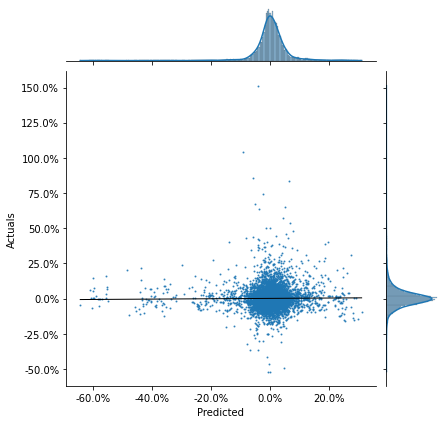

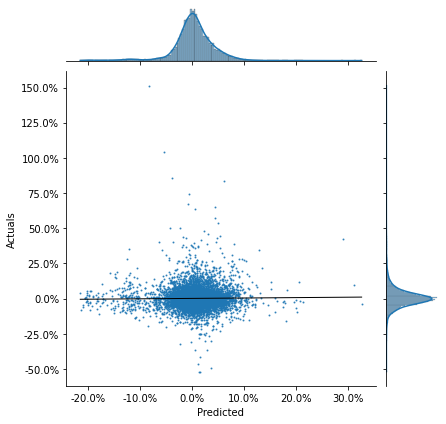

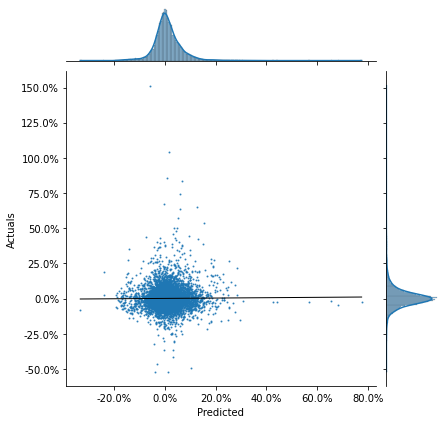

In [291]:
symbols = ("ADA", "SOL", "MANA", "MATIC", "TFUEL", "FLOW", "AVAX")

for name in model_names:
    print(name)
    #for symbol in symbols:
    plot_preds_scatter(eval_dict[f"{name}_predictions"])

In [292]:
eval_dict["rf_predictions"]

actuals  predicted
Symbol Date                           
ADA    2022-03-11 -0.000597  -0.002670
       2022-03-12  0.000548   0.008538
       2022-03-13  0.015078  -0.026976
       2022-03-14 -0.003871   0.014697
       2022-03-15  0.049287   0.029262
...                     ...        ...
TFUEL  2019-04-01 -0.050317  -0.039324
       2019-04-02 -0.086430   0.034475
       2019-04-03  0.099440  -0.007262
       2019-04-04 -0.034229   0.004689
       2019-04-05 -0.051466   0.010060

[7630 rows x 2 columns]

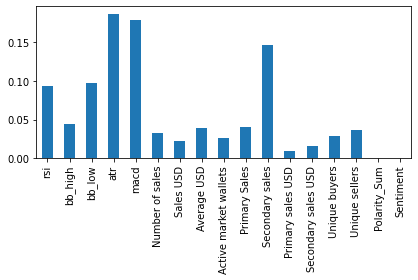

In [293]:
forest_importances = pd.Series(models[1].feature_importances_, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
fig.tight_layout()

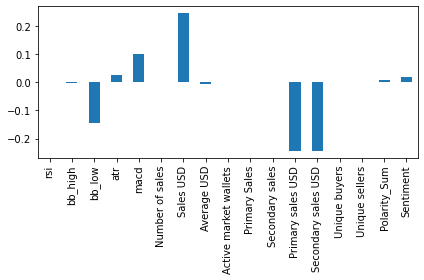

In [294]:
lr_importances = pd.Series(models[0].coef_, index=X.columns)

fig, ax = plt.subplots()
lr_importances.plot.bar(ax=ax)
fig.tight_layout()

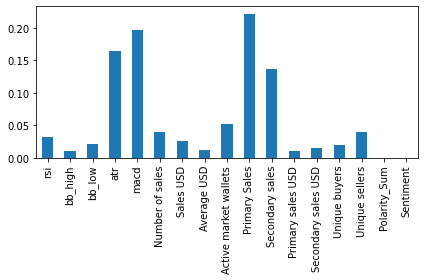

In [296]:
xgb_importances = pd.Series(models[2].feature_importances_, index=X.columns)

fig, ax = plt.subplots()
xgb_importances.plot.bar(ax=ax)
fig.tight_layout()

Output

In [301]:
eval_dict[f"{model_names[0]}_predictions"].to_csv('../data/signals/lr_predicted_returns.csv')
eval_dict[f"{model_names[1]}_predictions"].to_csv('../data/signals/rf_predicted_returns.csv')
eval_dict[f"{model_names[2]}_predictions"].to_csv('../data/signals/xgb_predicted_returns.csv')

### New Split

In [261]:
X

rsi   bb_high    bb_low       atr      macd  \
Symbol Date                                                            
ADA    2018-06-11  33.512455  0.216036  0.021987 -0.404601 -0.349924   
       2018-06-12  30.063208  0.269702 -0.021351 -0.405151 -0.383543   
       2018-06-13  28.857432  0.291623 -0.010164 -0.409419 -0.413876   
       2018-06-14  35.174686  0.254994  0.077835 -0.408323 -0.416873   
       2018-06-15  33.089452  0.282673  0.061770 -0.420484 -0.426485   
...                      ...       ...       ...       ...       ...   
TFUEL  2022-03-16  47.924529  0.091847  0.112104  0.145477 -0.495777   
       2022-03-17  50.268468  0.071962  0.129365  0.125531 -0.423620   
       2022-03-18  52.445625  0.054721  0.145075  0.130008 -0.340504   
       2022-03-19  53.545190  0.050250  0.152796  0.115289 -0.260929   
       2022-03-20  49.873470  0.064820  0.124119  0.087470 -0.229633   

                   Number of sales     Sales USD  Average USD  \
Symbol Date                                                     
ADA    2018-06-11           3381.0  4.260119e+04        12.60   
       2018-06-12           2903.0  3.698138e+04        12.74   
       2018-06-13           2272.0  5.126892e+04        22.57   
       2018-06-14           1926.0  4.576329e+04        23.76   
       2018-06-15           5253.0  5.051450e+04         9.62   
...                            ...           ...          ...   
TFUEL  2022-03-16          11714.0  5.468673e+07      4668.49   
       2022-03-17          13001.0  1.028586e+08      7911.59   
       2022-03-18          13745.0  8.581665e+07      6243.48   
       2022-03-19          15916.0  8.830517e+07      5548.20   
       2022-03-20          14760.0  4.390767e+07      2974.77   

                   Active market wallets  Primary Sales  Secondary sales  \
Symbol Date                                                                
ADA    2018-06-11                  660.0         2864.0            517.0   
       2018-06-12                  692.0         2296.0            607.0   
       2018-06-13                  718.0         1671.0            601.0   
       2018-06-14                  566.0         1556.0            370.0   
       2018-06-15                  641.0         4665.0            588.0   
...                                  ...            ...              ...   
TFUEL  2022-03-16                14188.0         2802.0           8912.0   
       2022-03-17                14414.0         3109.0           9892.0   
       2022-03-18                15830.0         3121.0          10624.0   
       2022-03-19                17014.0         4497.0          11419.0   
       2022-03-20                15276.0         4826.0           9934.0   

                   Primary sales USD  Secondary sales USD  Unique buyers  \
Symbol Date                                                                
ADA    2018-06-11           20244.22             22356.97          492.0   
       2018-06-12           18200.13             18781.24          504.0   
       2018-06-13           23514.14             27754.78          527.0   
       2018-06-14           14447.34             31315.95          432.0   
       2018-06-15           26308.40             24206.09          450.0   
...                              ...                  ...            ...   
TFUEL  2022-03-16         2356432.46          52330293.33         7755.0   
       2022-03-17         3957555.73          98901027.48         8040.0   
       2022-03-18         5639611.59          80177042.29         8538.0   
       2022-03-19         5475732.05          82829439.82         9487.0   
       2022-03-20         2497767.37          41409906.92         8709.0   

                   Unique sellers  Polarity_Sum  Sentiment  
Symbol Date                                                 
ADA    2018-06-11           280.0          0.00        0.0  
       2018-06-12           294.0          0.00        0.0  
       2018-06-13   

In [262]:
y

target_1d  target_2d  target_3d  target_4d  target_5d  \
Symbol Date                                                                
ADA    2018-06-11  -0.079092  -0.056023  -0.014077  -0.022222  -0.019274   
       2018-06-12  -0.032376   0.020132  -0.002495  -0.003722  -0.005159   
       2018-06-13   0.075489   0.012789   0.006017   0.001764   0.004719   
       2018-06-14  -0.046255  -0.027018  -0.021671  -0.012234  -0.006675   
       2018-06-15  -0.007393  -0.009142  -0.000626   0.003474  -0.003113   
...                      ...        ...        ...        ...        ...   
TFUEL  2022-03-16   0.022745   0.021875   0.018012   0.005732   0.006166   
       2022-03-17   0.021005   0.015653   0.000124   0.002063   0.003742   
       2022-03-18   0.010329  -0.010156  -0.004172  -0.000528   0.004854   
       2022-03-19  -0.030225  -0.011345  -0.004121   0.003490   0.009399   
       2022-03-20   0.007903   0.009193   0.014987   0.019555   0.015191   

                   target_6d  target_7d  target_14d  target_28d  
Symbol Date                                                      
ADA    2018-06-11  -0.017881  -0.013024   -0.020143   -0.008853  
       2018-06-12  -0.001561   0.000911   -0.019162   -0.008869  
       2018-06-13   0.006569   0.001405   -0.016410   -0.007186  
       2018-06-14  -0.010437  -0.012066   -0.025488   -0.011087  
       2018-06-15  -0.006250  -0.022649   -0.020334   -0.006514  
...                      ...        ...         ...         ...  
TFUEL  2022-03-16   0.006885   0.009688    0.013518    0.001409  
       2022-03-17   0.007528   0.011182    0.016350   -0.000717  
       2022-03-18   0.009554   0.007883    0.015864   -0.000663  
       2022-03-19   0.007476   0.009547    0.016414   -0.001336  
       2022-03-20   0.016332   0.022270    0.018807   -0.001178  

[9653 rows x 9 columns]

In [317]:
# backtest start and end date
start_bt = pd.to_datetime("2021-09-20")
end_bt = pd.to_datetime("2022-03-20")

# training start and end date
start_train = pd.to_datetime("2020-09-19")
end_train = pd.to_datetime("2021-09-19")

In [358]:
%%time
target = f'target_{lookahead}d'

model_names = ("ols", "rf", "xgb")

results_dict = {}

for symbol in symbols:
    lr = LinearRegression()
    rf = RandomForestRegressor()
    xgb = XGBRegressor()
    
    models = (lr, rf, xgb)
    
    X_train = X.loc[symbol,start_train:end_train, :]
    X_test = X.loc[symbol, start_bt:end_bt, :]
    
    y_train = y.loc[symbol,start_train:end_train,:].target_1d
    y_test = y.loc[symbol,start_bt:end_bt,:].target_1d
    
    results_dict[symbol] = {}
    
    for model_name, model in zip(model_names, models):
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        mse = mean_squared_error(y_test, preds)
        
        results_dict[symbol][model_name] =  (preds, mse)

CPU times: total: 13.5 s
Wall time: 4.86 s


Linear 

In [376]:
predicted_array = np.concatenate([results_dict[symbol]['ols'][0] for symbol in symbols])

In [390]:
out_df = y.filter(like=target).loc[:,start_bt:end_bt,:]
out_df["predicted"] = predicted_array
out_df = out_df.rename(columns={"target_1d": "actuals"})
out_df

actuals  predicted
Symbol Date                           
ADA    2021-09-20 -0.048375   0.019084
       2021-09-21  0.134664   0.031653
       2021-09-22  0.032319   0.020786
       2021-09-23 -0.019922   0.056849
       2021-09-24  0.015213   0.028074
...                     ...        ...
TFUEL  2022-03-16  0.022745   0.116089
       2022-03-17  0.021005   0.154950
       2022-03-18  0.010329   0.137294
       2022-03-19 -0.030225   0.128500
       2022-03-20  0.007903   0.075769

[1274 rows x 2 columns]

In [391]:
out_df.to_csv("../data/signals/lr_predicted_returns.csv")